In [0]:
import sys
!apt install -y caffe-cuda
import caffe

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path='/content/drive/My Drive/ICPR 2012 dataset/'

In [67]:
!ls '/content/drive/My Drive/ICPR 2012 dataset/Training'

A00_v2	A03_v2			images		      masks_split_train.npy
A01_v2	A04_v2			imgs_split_train.npy  mitosis_images
A02_v2	bboxes_split_train.npy	masks


In [0]:
import numpy as np
import pandas as pd
from skimage.color import rgb2hed
from skimage.measure import label, regionprops
from skimage.io import imread, imshow, imread_collection, concatenate_images
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
from __future__ import print_function
import tensorflow as tf
import random
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Dropout
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
import pickle
K.set_image_data_format('channels_last')



In [0]:
train_image_paths=['A00_v2/A00_01', 'A00_v2/A00_02', 'A00_v2/A00_03', 'A00_v2/A00_04', 'A00_v2/A00_05', 'A00_v2/A00_06', 'A00_v2/A00_07', 'A00_v2/A00_09',
                   'A01_v2/A01_00', 'A01_v2/A01_01', 'A01_v2/A01_02', 'A01_v2/A01_03', 'A01_v2/A01_05', 'A01_v2/A01_07', 'A01_v2/A01_08',
                   'A02_v2/A02_02', 'A02_v2/A02_04', 'A02_v2/A02_05', 'A02_v2/A02_06', 'A02_v2/A02_08', 'A02_v2/A02_09',
                   'A03_v2/A03_02', 'A03_v2/A03_03', 'A03_v2/A03_05', 'A04_v2/A04_06', 'A03_v2/A03_07', 'A03_v2/A03_08', 'A03_v2/A03_09',
                   'A04_v2/A04_00', 'A04_v2/A04_01', 'A04_v2/A04_02', 'A04_v2/A04_04', 'A04_v2/A04_05', 'A04_v2/A04_06', 'A04_v2/A04_08']

test_image_paths=['A00_v2/A00_00', 'A00_v2/A00_08',
                  'A01_v2/A01_04', 'A01_v2/A01_06', 'A01_v2/A01_09',
                  'A02_v2/A02_00', 'A02_v2/A02_01', 'A02_v2/A02_03', 'A02_v2/A02_07',
                  'A03_v2/A03_00', 'A03_v2/A03_01', 'A03_v2/A03_04',
                  'A04_v2/A04_03', 'A04_v2/A04_07', 'A04_v2/A04_09']

In [0]:
X_train=[]
Y_train=[]
bb_train=[]
X_test=[]
Y_test=[]
bb_test=[]

def crop(im,height,width,imgheight,imgwidth):
    for i in range(int(imgheight/height)):
        for j in range(int(imgwidth/width)):
            box = (j*width, i*height, (j+1)*width, (i+1)*height)
            yield im.crop(box)


for k in range(len(train_image_paths)):

  image = Image.open(path+'Training/'+train_image_paths[k]+".bmp")
  imgwidth, imgheight = image.size
  height = int(imgheight/4)
  width =  int(imgwidth/4)
  start_num = 0
  for x,piece in enumerate(crop(image,height,width,imgheight,imgwidth),start_num):
      img=Image.new('RGB', (width,height), 255)
      img.paste(piece)
      X_train.append(np.array(img))
      img.save(path+'Training/images/'+train_image_paths[k][7:]+'_'+str(x+1)+".bmp")
  
  height,width=image.size

  patch = np.full((height,width),255)

  f = open(path+'Training/'+train_image_paths[k]+".csv", "r")
  
  for line in f:
    lines=line.split()
    pixels=lines[0].split(",")
    
    for i in range(0,len(pixels),2):
      patch[int(pixels[i+1])][int(pixels[i])]=0
  
  imgwidth, imgheight = image.size
  height = int(imgheight/4)
  width =  int(imgwidth/4)
  for i in range(4):
    for j in range(4):
      Y_train.append(patch[i*width:(i+1)*width,j*height:(j+1)*height])
      mask_0 = np.invert(patch[i*width:(i+1)*width,j*height:(j+1)*height])
      lbl_0 = label(mask_0)
      props = regionprops(lbl_0)
      bb_train.append(props[1:])
  
X_train=np.array(X_train)
Y_train=np.array(Y_train)
bb_train=np.array(bb_train)


for k in range(len(test_image_paths)):

  image = Image.open(path+'Testing/'+test_image_paths[k]+".bmp")
  imgwidth, imgheight = image.size
  height = int(imgheight/4)
  width =  int(imgwidth/4)
  start_num = 0
  for x,piece in enumerate(crop(image,height,width,imgheight,imgwidth),start_num):
      img=Image.new('RGB', (width,height), 255)
      img.paste(piece)
      X_test.append(np.array(img))
      img.save(path+'Testing/images/'+test_image_paths[k][7:]+'_'+str(x+1)+".bmp")
  
  height,width=image.size

  patch = np.full((height,width),255)

  f = open(path+'Testing/'+test_image_paths[k]+".csv", "r")
  
  for line in f:
    lines=line.split()
    pixels=lines[0].split(",")
    
    for i in range(0,len(pixels),2):
      patch[int(pixels[i+1])][int(pixels[i])]=0
  
  imgwidth, imgheight = image.size
  height = int(imgheight/4)
  width =  int(imgwidth/4)
  for i in range(4):
    for j in range(4):
      Y_test.append(patch[i*width:(i+1)*width,j*height:(j+1)*height])
      mask_0 = np.invert(patch[i*width:(i+1)*width,j*height:(j+1)*height])
      lbl_0 = label(mask_0)
      props = regionprops(lbl_0)
      bb_test.append(props[1:])
  
X_test=np.array(X_test)
Y_test=np.array(Y_test)
bb_test=np.array(bb_test)

In [0]:
i=0
ctr=0
  
for i in range(len(X_train)):
  image=Image.fromarray(X_train[i], 'RGB')  
  for prop in bb_train[i]:
    im = image.crop((max(prop.bbox[1]-20,0), max(prop.bbox[0]-20,0), min(prop.bbox[3]+20,511), min(prop.bbox[2]+20,511)))
    im=im.resize((64,64), Image.NEAREST)
    im.save(path+'Training/mitosis_images/'+str(ctr)+'.bmp')
    ctr+=1
  i+=1

In [0]:
np.save(path+'Training/imgs_split_train.npy', X_train)
np.save(path+'Training/masks_split_train.npy', Y_train)
np.save(path+'Training/bboxes_split_train.npy', bb_train)
np.save(path+'Testing/imgs_split_test.npy', X_test)
np.save(path+'Testing/masks_split_test.npy', Y_test)
np.save(path+'Testing/bboxes_split_test.npy', bb_test)

In [0]:
X_train=np.load(path+'Training/imgs_split_train.npy')
Y_train=np.load(path+'Training/masks_split_train.npy')
bb_train=np.load(path+'Training/bboxes_split_train.npy')
X_test=np.load(path+'Testing/imgs_split_test.npy')
Y_test=np.load(path+'Testing/masks_split_test.npy')
bb_test=np.load(path+'Testing/bboxes_split_test.npy')

(521, 521, 3)


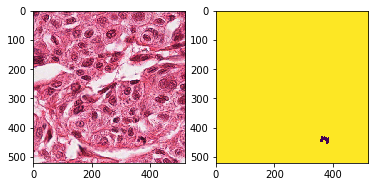

In [6]:
print(X_train[0].shape)
plt.subplot(1,2,1)
plt.imshow(X_train[255])
plt.subplot(1,2,2)
plt.imshow(Y_train[255])

(521, 521, 3)
(521, 521)
Found bbox (299, 74, 330, 104)


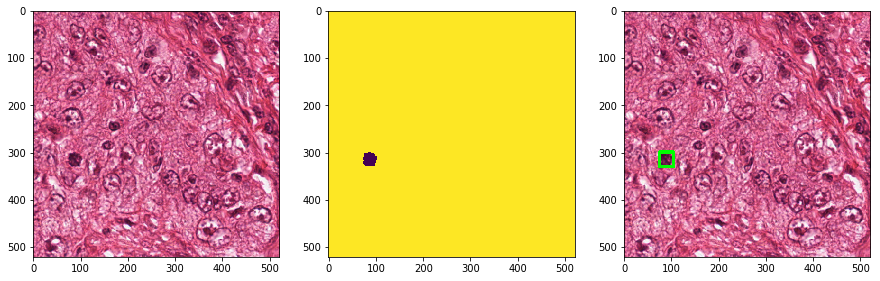

In [54]:
print(X_train[0].shape)
print(Y_train[0].shape)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
ax1.imshow(X_train[1,:,:,:])
ax2.imshow(Y_train[1])
img_1 = X_train[1,:,:,:].copy()
for prop in bb_train[1]:
    print('Found bbox', prop.bbox)
    cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (0, 255, 0), 5)
ax3.imshow(img_1)

In [0]:
img_rows = 512
img_cols = 512

In [9]:
smooth = 1.

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
  
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet():
    inputs = Input((img_rows, img_cols, 1))

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[mean_iou])

    return model

from skimage.color import rgb2hed

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols,1), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = rgb2hed(resize(imgs[i], (img_cols, img_rows,3), preserve_range=True))[:,:,0:1]
    return imgs_p


    
imgs_train = preprocess(X_train)
imgs_mask_train = preprocess(Y_train)

imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train /= 255.  # scale masks to [0, 1]

model = get_unet()
model_checkpoint = ModelCheckpoint(path+'weights.h5', monitor='val_loss', save_best_only=True)

print("Training....")
model.fit(imgs_train, imgs_mask_train, batch_size=6, nb_epoch=50, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint])

icpr_unet_file = 'icpr_unet.pkl'
icpr_unet_model_pkl = open(path+icpr_unet_file, 'wb')
pickle.dump(model,icpr_unet_model_pkl)
icpr_unet_model_pkl.close()

imgs_test = preprocess(X_test)

imgs_test = imgs_test.astype('float32')
imgs_test -= mean
imgs_test /= std

model.load_weights(path+'weights.h5')
print("Predicting....")
imgs_mask_predict = model.predict(imgs_test, verbose=1)
np.save(path+'imgs_mask_predict.npy', imgs_mask_predict)




Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Training....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 448 samples, validate on 112 samples
Epoch 1/50
448/448 [==============================] - 36s 80ms/step - loss: 0.0000e+00 - mean_iou: 0.4663 - val_loss: 0.0000e+00 - val_mean_iou: 0.4726
Epoch 2/50
448/448 [==============================] - 24s 54ms/step - loss: 0.0000e+00 - mean_iou: 0.4726 - val_loss: 0.0000e+00 - val_mean_iou: 0.4725
Epoch 3/50
448/448 [==============================] - 24s 54ms/step - loss: 0.0000e+00 - mean_iou: 0.4725 - val_loss: 0.0000e+00 - val_mean_iou: 0.4725
Epoch 4/50
448/448 [==============================] - 24s 54ms/step - loss: 0.0000e+00 - mean_iou: 0.4725 - val_loss: 0.0000e+00 - val_mean_iou: 0.4725
Epoch 5/50
448/448 [==============================] - 25s 55ms/step - loss: 0.0000e+00 - mean_iou: 0.4725 - val_loss: 0.0000e+00 - val_mean_iou: 0.4725
Epoch 6/50
448/448 [==============================] - 25s 55ms/step - loss: 0.0000e+00 - mean_iou: 0.4725 - val_loss: 0.0000e+00 - val_mean_iou: 0.4725
Epoch 7/50
448/448 [======================

In [0]:
imgs_mask_predict=np.load(path+'imgs_mask_predict.npy')

In [0]:
for k in range(len(imgs_mask_predict)):
  for i in range(img_rows):
    for j in range(img_cols):
      if(imgs_mask_predict[k,i,j,0]<0.1):
        imgs_mask_predict[k,i,j,0]=0
      else:
        imgs_mask_predict[k,i,j,0]=255
  
np.save(path+'imgs_mask_predict.npy', imgs_mask_predict)    

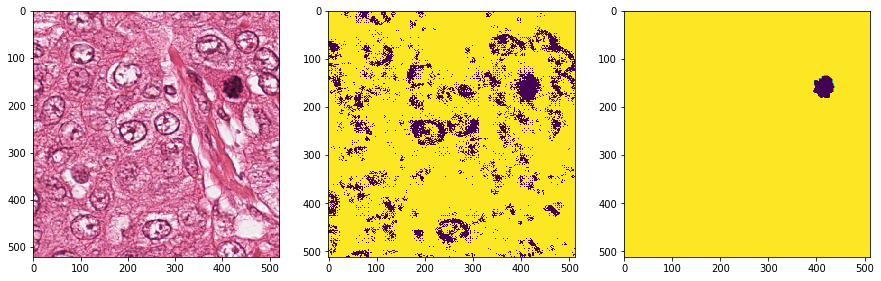

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
ax1.imshow(X_test[-1])
ax2.imshow(imgs_mask_predict[-1,:,:,0])
truth=resize(Y_test[-1], (img_cols, img_rows), preserve_range=True)
ax3.imshow(truth)

Object Detection on Segmented images


In [0]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

train_images = np.zeros((len(Y_train), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
test_images = np.zeros((len(imgs_mask_predict), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for i in range(len(Y_train)):
    train_images[i] = resize(Y_train[i], (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)   
    
sizes_test = []
for i in range(len(imgs_mask_predict)):
    sizes_test.append([imgs_mask_predict[i,:,:,0].shape[0], imgs_mask_predict[i,:,:,0].shape[1]])
    test_images[i] = resize(imgs_mask_predict[i,:,:,0], (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)

In [0]:
def store_bounding_boxes(img, train_id, mask_id, rotby_90):
    ret, thresh = cv2.threshold(img, 127, 255, 0)
    contours = cv2.findContours(thresh.astype(np.uint8), 1, 2)
    cnt = contours[0]
        
    x, y, w, h = cv2.boundingRect(cnt)    
    
    x = x * (IMG_WIDTH/img.shape[1])
    w = w * (IMG_WIDTH/img.shape[1])
    y = y * (IMG_WIDTH/img.shape[0])
    h = h * (IMG_WIDTH/img.shape[0])
    
    if(x > IMG_WIDTH-1):
        x = IMG_WIDTH-1
    if(y > IMG_HEIGHT-1):
        y = IMG_HEIGHT-1
    if(x+w > IMG_WIDTH-1):
        w = IMG_WIDTH-1 - x
    if(y+h > IMG_HEIGHT-1):
        h = IMG_HEIGHT-1 - y
        
    bbdict = { "train_id": train_id, "mask_id": mask_id, "rotby_90": rotby_90, "x": x, "y": y, "w": w, "h": h}
    return bbdict
  
path_bboxes_csv = path+'obj_detect_train_bboxes.csv'
if not os.path.isfile(path_bboxes_csv):
    bboxes = pd.DataFrame(columns=["train_id", "mask_id", "rotby_90", "x", "y", "w", "h"])
    row_count = 1
    for i in range(len(Y_train)):
        mask_ = Y_train[i]
        for r in range(4):
            bboxes.loc[row_count] = store_bounding_boxes(np.array(np.rot90(mask_, r),dtype='float32'), i, i, r)
            row_count += 1
    bboxes.to_csv(path_bboxes_csv, index=False)
else:
    bboxes = pd.read_csv(path_bboxes_csv)
    
GRID_DIM = 12
GRID_PIX = IMG_WIDTH//GRID_DIM
BATCH_SIZE = 14

train_ids_df = pd.DataFrame(columns=["idx", "id_"])
cnt = 0
for i in range(len(Y_train)):
    train_ids_df.loc[cnt] = { "idx": i, "id_": i}
    cnt += 1

train_ids_df = train_ids_df.set_index(['idx'])

bboxes['grid_row'] = bboxes['y']//GRID_PIX
bboxes['grid_column'] = bboxes['x']//GRID_PIX

bboxes['grid_center_x'] = bboxes['grid_column'] * GRID_PIX + GRID_PIX/2
bboxes['grid_center_y'] = bboxes['grid_row'] * GRID_PIX + GRID_PIX/2

bboxes['box_center_x'] = bboxes.x + bboxes['w']/2
bboxes['box_center_y'] = bboxes.y + bboxes['h']/2

bboxes['new_x'] = (bboxes.box_center_x - bboxes.grid_center_x)/(IMG_WIDTH)
bboxes['new_y'] = (bboxes.box_center_y - bboxes.grid_center_y)/(IMG_HEIGHT)

bboxes['new_w'] = np.sqrt(bboxes.w/(IMG_WIDTH))
bboxes['new_h'] = np.sqrt(bboxes.h/(IMG_WIDTH))

bboxes['confidence'] = 1

bboxes['box_area'] = bboxes.new_w*bboxes.new_h


In [0]:
mask_count = 1
#Set maximum bounding boxes allowed per grid cell
MAX_BB_CNT = 2

def get_grid_info(tr_id, rotby_90):
    df = bboxes.loc[(bboxes.train_id == tr_id) & (bboxes.rotby_90 == rotby_90), 'grid_row':'box_area']
    df.drop(['grid_center_x', 'grid_center_y','box_center_x', 'box_center_y',], axis = 1, inplace=True)
    df = df.sort_values(['grid_column', 'grid_row', 'box_area'], ascending=False)
    #print(len(df))
    global mask_count
    mask_count += len(df)
    label_info = np.zeros(shape=(GRID_DIM, GRID_DIM, MAX_BB_CNT, 5),  dtype=np.float32) + 0.000001
    
    for ind, row in df.iterrows():
        i = int(row[0])
        j = int(row[1])
        for b in range(MAX_BB_CNT):
            if(label_info[i, j, b][4] != 1.0):
                label_info[i, j, b] = np.array(row[2:7])
                break
    return label_info

def get_labels(counts, rotations):
  grid_info = np.zeros(shape=(BATCH_SIZE, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5), dtype=np.float32)
  for i, c in enumerate(counts):
      tr_id = train_ids_df.loc[c, 'id_']
      grid_info[i] = get_grid_info(tr_id, rotations[i])
  grid_info = np.reshape(grid_info, newshape=[BATCH_SIZE, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
  return grid_info

def get_images(counts, rotations):
    images = np.zeros(shape=(BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
    for i, c in enumerate(counts):
        images[i] = np.rot90(train_images[c], rotations[i])
    return images

def next_batch():
    rotations = []
    rand_counts = []
    for i in range(BATCH_SIZE):
        rotations.append(random.randint(0, 3))
        rand_counts.append(random.randint(0, 560))
    return get_images(rand_counts, rotations), get_labels(rand_counts, rotations)

tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, IMG_WIDTH, IMG_HEIGHT, 1])
Y_ = tf.placeholder(tf.float32, [None, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
lr = tf.placeholder(tf.float32)

def process_logits(logits, name=None):
    net = tf.reshape(logits, [-1, GRID_DIM*1, GRID_DIM*1, MAX_BB_CNT*5*16, 1])
    net = tf.layers.average_pooling3d(net, [1, 1, 16], [1, 1, 16], padding="valid")

    net = tf.reshape(net, [-1, GRID_DIM*GRID_DIM*MAX_BB_CNT, 5]) #GRID_DIM = 12
    net = tf.transpose(net, [1, 2, 0])        

    logits_tensor = tf.map_fn(lambda x:
                            tf.stack([
                                tf.tanh(x[0]),
                                tf.tanh(x[1]),
                                tf.sqrt(tf.sigmoid(x[2])),
                                tf.sqrt(tf.sigmoid(x[3])),
                                tf.sigmoid(x[4])
                            ]), net)

    logits_tensor = tf.transpose(logits_tensor, [2, 0, 1])
    logits_tensor = tf.reshape(logits_tensor, [-1, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])

    return logits_tensor

def normalize_yolo_loss(processed_logits, lambda_coords, lambda_noobj):
    yolo_loss = tf.reduce_sum(tf.squared_difference(labels, processed_logits), axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)

    yolo_loss = tf.stack([tf.multiply(lambda_coords, yolo_loss[0]), 
                          tf.multiply(lambda_coords, yolo_loss[1]),
                          yolo_loss[2],
                          yolo_loss[3],
                          tf.multiply(lambda_noobj,yolo_loss[4])])
    yolo_loss = tf.reduce_sum(yolo_loss)

    return  yolo_loss

def l_relu(features):
    return tf.nn.leaky_relu(features, 0.1)

In [19]:
# Below code need optimization may be by using Variable Scope.
def squeeze_module(x, dim, idx):
    name = 'conv_' + idx + '_sq'
    return tf.layers.conv2d(x, filters=dim, kernel_size=1, strides=1, padding="same", 
                           activation=l_relu, name=name)

def expand_module(x, dim, idx):
    name = 'conv_' + idx + '_ex_' + '0'
    net1 = tf.layers.conv2d(x, filters=dim, kernel_size=1, strides=1, padding="same", 
                           activation=l_relu, name=name)
    name = 'conv_' + idx + '_ex_' + '1'
    net2 = tf.layers.conv2d(x, filters=dim, kernel_size=3, strides=1, padding="same", 
                           activation=l_relu, name=name) 
    return tf.concat([net1, net2], 3)

def fire_module(input_tensor, squeeze_dim, expand_dim, idx):
    net = squeeze_module(input_tensor, squeeze_dim, idx)
    net = expand_module(net, expand_dim, idx)
    return net

# Below code need optimization may be by using Variable Scope.


net = tf.layers.conv2d(X, filters=32, kernel_size=1, strides=1, padding="same", 
                       activation=l_relu, name='conv0') #512 

net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #256

net = fire_module(net, 32, 64, '0')
net = fire_module(net, 32, 64, '1')
net = fire_module(net, 32, 64, '2')

net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #128


net = fire_module(net, 64, 96, '3')
net = fire_module(net, 64, 96, '4')
net = fire_module(net, 64, 96, '5')


net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #64

net = fire_module(net, 128, 160, '6')
net = fire_module(net, 128, 160, '7') 
net = fire_module(net, 128, 128, '8')


net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #32

net = fire_module(net, 256, 512, '9')
net = fire_module(net, 256, 512, '10')
net = fire_module(net, 256, 512, '11')

net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #16

net = fire_module(net, 512, 1024, '12')
net = fire_module(net, 512, 1024, '13')
net = fire_module(net, 512, 1024, '14')

logits = tf.layers.conv2d(net, filters=MAX_BB_CNT*5*16, kernel_size=1, strides=1, padding="same",
                       activation=None, name='conv40') #16

processed_logits = process_logits(logits)

labels = Y_

lambda_coords = tf.constant(5.0)
lambda_noobj = tf.constant(0.5)

yolo_loss = normalize_yolo_loss(processed_logits, lambda_coords, lambda_noobj)

train_op = tf.train.AdamOptimizer(lr).minimize(yolo_loss)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_count = 0
display_count = 1
global mask_count


Instructions for updating:
Use keras.layers.average_pooling3d instead.
Instructions for updating:
Use tf.cast instead.


In [20]:
for i in range(1000):
    batch_X, batch_Y = next_batch()
    batch_count += 1
    train_loss, _ = sess.run([yolo_loss, train_op], {X: batch_X, Y_: batch_Y, lr: 0.0001})

    if(i % 100 == 0):
        print(str(display_count) + " training loss(" + str(mask_count) + "): " + str(train_loss))
        display_count +=1
    mask_count = 0
print("Done!")


InvalidArgumentError: ignored